# 1. Preprocessing
# 2. Build the Arhitecture
# 3. Training and Testing Functions
# 4. Hyperparamter Optimization with Optuna
# 5. Post-Processing

In [1]:
#modify this cell accordingly if you use google-colab. Always upload the zip folders to your drive then unzip
# them to local colab directory. Otherwise, uploading thousands of images takes hours as opposed to minutes. Also,
# training will be ridiculous slow if you try to fetch the images from your drive during training. 
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = '/content/drive/MyDrive/ColabNotebooks/ImageClassification'
    data_dir = root_dir + '/simpsons_dataset'
    !unzip '/content/drive/MyDrive/ColabNotebooks/ImageClassification/simpsons_dataset/test.zip' -d '/content/sample_data'
    !unzip '/content/drive/MyDrive/ColabNotebooks/ImageClassification/simpsons_dataset/train.zip' -d '/content/sample_data'
    train_dir = '/content/sample_data/train'
    test_dir = '/content/sample_data/test'
    ext_dir =  root_dir + '/Results'
    #add your modules here.
    !pip install optuna
    !pip install -U git+https://github.com/albumentations-team/albumentations    

In [2]:
#==============================#
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import albumentations as A  
from albumentations.pytorch import ToTensorV2
#===========================#
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms as T
import torch.nn.functional as F
from torchvision import datasets
from torch import optim
import optuna
#============================#
import os
import time
import random
import joblib
import sys
import shutil
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore') 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
#==============================#
%matplotlib inline

GeForce RTX 2070 Super


# 1. Preprocessing

In [3]:
data_dir='simpsons_dataset_resized/'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
ext_dir =  'Results/'

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
def CreateTrainTest(data_dir, test_ratio = 0.2):
    #create the class list
    class_list = []
    for (dirpath, dirnames, filenames) in os.walk(data_dir):
        if len(dirnames)!=0:
            class_list = dirnames
            
    #create train and test folders in data_dir
    for cls in class_list:
        os.makedirs(data_dir +'train/' + cls)
        os.makedirs(data_dir +'test/' + cls)
    
    for i in class_list:
        source = data_dir + '/' + i

        #get all filenames in class-i
        allFileNames = os.listdir(source)
        np.random.shuffle(allFileNames)

        #make the split of filanames
        
        train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - test_ratio))])
        #path-list for train and testing filenames
        train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

        #copy the files in /train and /test directories 
        for name in train_FileNames:
            shutil.copy(name, data_dir +'/train/' + i)
        for name in test_FileNames:
            shutil.copy(name, data_dir +'/test/' + i)
    
    print('done!')

In [6]:
#grab from data_dir and resize-save to save_dir
def ResizeSave(data_dir,save_dir,dim = (224,224),RGB = True):
    for (dirpath, dirnames, filenames) in os.walk(data_dir):
        new_paths = dirpath.replace(data_dir,save_dir)    
        if not os.path.exists(new_paths):
            os.umask(0)
            os.makedirs(new_paths, mode=0o777)
        for names in filenames:
            if RGB:
                img = Image.open(os.path.join(dirpath,names)).convert("RGB")

            else:
                img = Image.open(os.path.join(dirpath,names)).convert("L")
            img  = img.resize(dim,Image.NEAREST)
            img = img.save(os.path.join(new_paths,names))
    
    print('resizing done!')


In [7]:
def GetDataPaths(train_dir,test_dir):
    class_list = []
    train_image_paths = []
    test_image_paths = []
    for (dirpath, dirnames, filenames) in os.walk(train_dir):

        if len(dirnames)!=0:
            class_list = dirnames
        for names in filenames:
            train_image_paths.append(os.path.join(dirpath,names))
    for (dirpath, dirnames, filenames) in os.walk(test_dir):
        for names in filenames:
            test_image_paths.append(os.path.join(dirpath,names))

    random.shuffle(train_image_paths)
    random.shuffle(test_image_paths)
    
    return train_image_paths,test_image_paths,class_list

train_image_paths,test_image_paths,class_list = GetDataPaths(train_dir, test_dir)
num_classes = len(class_list)
idx_to_class = {i:j for i, j in enumerate(class_list)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

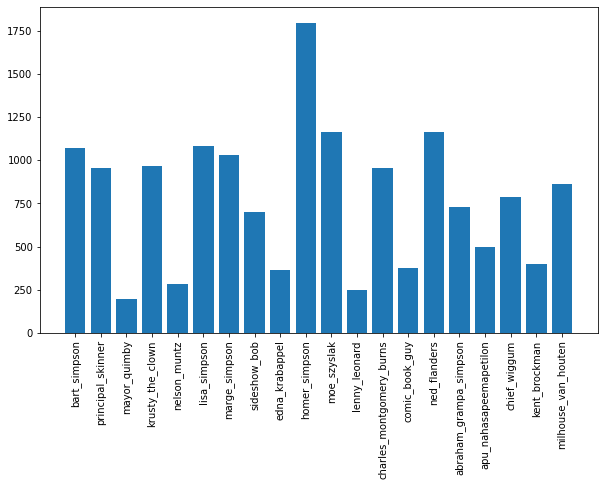

In [8]:
def ShowClassDist(train_dir):
    class_counts = []
    for (dirpath, dirnames, filenames) in os.walk(train_dir):
        if len(filenames)>0:
            class_counts.append(len(filenames))

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(class_list, class_counts)
    plt.xticks(fontsize=10, rotation=90)
    plt.show()
ShowClassDist(train_dir)

In [9]:
class SimpsonsDataset(Dataset):
    def __init__(self, image_paths, transform = None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        img = Image.open(image_filepath).convert("RGB")
        
        
        #class name and tag
        label = image_filepath.split('/')[-2] 
        label = class_to_idx[label]
        if self.transform is not None:
            img = self.transform(image=np.array(img))["image"]
        else:
            tfm = ToTensorV2()
            img = tfm(image = np.array(img))["image"]
            
        
        return img, label


In [10]:
def GetSampleWeights(train_image_paths):
    class_weights = []
    for (dirpath, dirnames, filenames) in os.walk(train_dir):
        if len(filenames)>0:
            class_weights.append(1000.*1/len(filenames))

    sample_weights = [0]*len(train_image_paths)
    for i in range(len(train_image_paths)):
        label = train_image_paths[i].split('/')[-2]
        class_weight = class_weights[class_to_idx[label]]
        sample_weights[i] = class_weight
        
    return sample_weights,torch.FloatTensor(class_weights).to(device)

In [11]:
sample_weights,class_weights = GetSampleWeights(train_image_paths)

In [12]:
def GetLoaders(train_batch_size,test_batch_size):
    mean = [0.485, 0.456, 0.406]
    std =  [0.229, 0.224, 0.225]
    training_transforms = A.Compose([#A.HorizontalFlip(p=0.5),
                                     #A.VerticalFlip(p=0.5),
                                     A.GridDistortion(p=0.2),
                                     A.GaussianBlur(p=0.2),
                                     A.RandomBrightness(p=0.2),
                                     A.Normalize(mean,std),
                                     ToTensorV2()])
    
    test_transforms = A.Compose([A.Normalize(mean,std),
                                        ToTensorV2()])
    
    train_set = SimpsonsDataset(train_image_paths, transform = training_transforms)
    #sample_weights,_ = GetSampleWeights(train_image_paths)
    #sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights),replacement=True)
    
    train_loader = DataLoader(train_set, batch_size = train_batch_size,sampler = None,drop_last=True )
    test_set  = SimpsonsDataset(test_image_paths, transform = test_transforms)
    test_loader  = DataLoader(test_set, batch_size = test_batch_size,drop_last=True)

    
    return train_loader, test_loader

# 2. Build the Arhitecture

In [13]:
#helper functions
def Get2dConv(in_channels,out_channels):
    
    return nn.Sequential( nn.Conv2d(in_channels,out_channels,kernel_size=3),
                          nn.ReLU(inplace=True),
                          nn.BatchNorm2d(out_channels),
                          nn.MaxPool2d(kernel_size=3)
                        )
def GetLinear(in_features,out_features,p):
    
    return nn.Sequential( nn.Linear(in_features,out_features),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(out_features),
                        nn.Dropout(p)
                      )


In [14]:

class SimpsonsModel(nn.Module):
    def __init__(self,p=0.):
        super(SimpsonsModel,self).__init__()
        self.p = p
        self.conv1 = Get2dConv(in_channels = 3, out_channels = 128)
        self.conv2 = Get2dConv(in_channels = 128, out_channels = 64)
        self.conv3 = Get2dConv(in_channels = 64, out_channels = 32)
      
        self.fc1 = GetLinear(in_features = 32*7*7,out_features=64,p=self.p)
        self.fc2 = GetLinear(in_features = 64,out_features=32,p=self.p)
        
        self.out = nn.Linear(in_features=32,out_features=num_classes)
     
    def num_flat_features(self, t):
        size = t.size()[1:]  
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def forward(self, t):
        t = self.conv1(t)
        t = self.conv2(t)
        t = self.conv3(t)
        
        t = t.view(-1, self.num_flat_features(t))
        t = self.fc1(t)
        t = self.fc2(t)
 
        t = self.out(t)
        
        return t

In [15]:
summary(SimpsonsModel(),(3,224,224),depth=1)

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 74, 74]         3,840
├─Sequential: 1-2                        [-1, 64, 24, 24]          73,920
├─Sequential: 1-3                        [-1, 32, 7, 7]            18,528
├─Sequential: 1-4                        [-1, 64]                  100,544
├─Sequential: 1-5                        [-1, 32]                  2,144
├─Linear: 1-6                            [-1, 20]                  660
Total params: 199,636
Trainable params: 199,636
Non-trainable params: 0
Total mult-adds (M): 561.75
------------------------------------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 101.56
Params size (MB): 0.76
Estimated Total Size (MB): 102.89
------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 74, 74]         3,840
├─Sequential: 1-2                        [-1, 64, 24, 24]          73,920
├─Sequential: 1-3                        [-1, 32, 7, 7]            18,528
├─Sequential: 1-4                        [-1, 64]                  100,544
├─Sequential: 1-5                        [-1, 32]                  2,144
├─Linear: 1-6                            [-1, 20]                  660
Total params: 199,636
Trainable params: 199,636
Non-trainable params: 0
Total mult-adds (M): 561.75
------------------------------------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 101.56
Params size (MB): 0.76
Estimated Total Size (MB): 102.89
------------------------------------------------------------------------------------

# 3. Training and Testing Functions

In [16]:
def TrainModel(trial,model, train_loader, optimizer,epoch,log_int):
   
    # set to train mode
    model.train()
    model.to(device)
    
    # This works well with logsoftmax.
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # compute the train loss and correct predictions per epoch
    train_loss = 0.0
    total_train_correct = 0
    
    
    for i,(inputs, targets) in enumerate(tqdm(train_loader,desc=f'training{epoch}')):
        torch.cuda.empty_cache()
        inputs = inputs.to(device)
        targets = targets.to(device)
        

        #In default, pytorch accumulates the gradient, zero out before each backpropagation.
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)

        # compute the loss
        loss = criterion(outputs, targets)

        # backpropagate the gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)

        # compute the predictions
        predictions = outputs.argmax(dim=1)

        # boolen compare the predictions vs targets and create the correct count tensor
        correct_counts = predictions.eq(targets)

        # accumulate the total train correct and update over the batches.
        total_train_correct += correct_counts.sum().item()


    # training loss and training accuracy
    avg_train_loss = train_loss/len(train_loader.dataset) 
    avg_train_acc = total_train_correct/float(len(train_loader.dataset))
    if epoch%log_int==0:
        print(f'train_loss: {avg_train_loss:0.5f} train_acc: {avg_train_acc:0.2f}')
    
    trial.report(avg_train_acc,epoch)
    if trial.should_prune():
        print(f'Pruned when acc:{avg_train_acc:0.4f} epoch: {epoch}\n')
        raise optuna.TrialPruned()
    
    return avg_train_acc

In [17]:
def TestModel(model, test_loader,epoch,log_int):
    # For testing, no need to track gradients. 
    model.eval()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.
    total_test_correct = 0
    with torch.no_grad():
        for j,(inputs, targets) in enumerate(tqdm(test_loader,desc='testing')):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass
            outputs = model(inputs)

            # compute the loss
            loss = criterion(outputs, targets)

            # compute the loss for the batch and add it to total test_loss
            test_loss += loss.item() * inputs.size(0)

            # compute the predictions
            predictions = outputs.argmax(dim=1)

            # boolen compare the predictions vs labels and create the correct count tensor
            correct_counts = predictions.eq(targets)

            # accumulate the total test correct and update over the batches.
            total_test_correct += correct_counts.sum().item()

    # test loss and test accuracy
    avg_test_loss = test_loss/len(test_loader.dataset) 
    avg_test_acc = total_test_correct/float(len(test_loader.dataset))
    if epoch%log_int==0:
        print(f'test_loss: {avg_test_loss:0.4f} test_acc: {avg_test_acc:0.2f}\n')

    return avg_test_acc

In [18]:
def GetStudyDataFrame(study = optuna.study.Study,name='StudyDataFrame',
                      drop_info = ['state','datetime_start','datetime_complete'],
                      save = True):
    df_study = study.trials_dataframe().drop(drop_info, axis=1)
    x = []
    for i in range(len(df_study)):
        mins = round(df_study['duration'][i].seconds/60,ndigits=2)
        x.append(mins)
    df_study['duration'] = x
    df_study = df_study.sort_values(by='value',ascending=False)
    if save:
        path = ext_dir +'/'+ name +'.csv'
        df_study.to_csv(path,index=False)
    
    return df_study

In [19]:
def SaveModel(model,optimizer, name,beststats):
    checkpoint = { 'state_dict':  model.state_dict(),
                   'optim_state': optimizer.state_dict(),
                   'best_stats':  beststats
                 }
    path = ext_dir + "/" + name +".pth"
    torch.save(checkpoint, path )

In [20]:
def LoadModel(model,filepath,train_mode = False):
    #load the model and assign the pre-trained weights
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    model.best_scores = checkpoint['best_stats']
    
    #if train required
    if train_mode:        
        for parameter in model.parameters():
            parameter.requires_grad = False
        optimizer.load_state_dict(checkpoint['optim_state'])
        
        return model,optimizer
    
    else:
        return model

# 4. Hyperparamter Optimization with Optuna

In [21]:
#these is only for the final single trial training.
def SuggestParams(trial):
    cfg = {'train_batch_size' : trial.suggest_int('train_batch_size',32,36),
          'lr' : trial.suggest_float('lr', 0.006753 , 0.006753),
           'p':trial.suggest_float('p',0.086042,0.086042),
          'optimizer': trial.suggest_categorical('optimizer',[optim.Adam]),
        }
  
    return cfg

In [22]:
#works in parallel as well.
model_id = 'SimsModelCustom'
scores = [0.]
def objective(trial):
    max_acc = 0.
    cfg = SuggestParams(trial)

    train_loader, test_loader = GetLoaders(cfg['train_batch_size'], test_batch_size = 4)
    model = SimpsonsModel(cfg['p'])
    optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
    print(f'Trial : {trial.number} starting....\n')

    n_epochs=100
    for epoch in range(n_epochs + 1):
        train_acc = TrainModel(trial,model, train_loader, optimizer,epoch,log_int=10)
        test_accuracy = TestModel(model,test_loader,epoch,log_int=10)
        
        if test_accuracy > max_acc:
            max_acc = test_accuracy

    if max(scores) < max_acc:
        beststats = {'BestAcc':     max_acc ,  
                    'lr':           cfg['lr'],
                    'batch_size':   cfg['train_batch_size'],
                  }
      #save the best of each model over all trials.
        SaveModel(model,optimizer,model_id,beststats)
    
    #register all the scores from each trial
    scores.append(max_acc)
        
    return test_accuracy

In [23]:
def StartStudy(study_name = 'SimsStudy',sampler = optuna.samplers.TPESampler(),n_trials=1,n_jobs=1):
    
    pruner = optuna.pruners.MedianPruner(n_startup_trials=2,n_warmup_steps=40)
    study = optuna.create_study(study_name=study_name,sampler=sampler,pruner=pruner, direction='maximize')
    study.optimize(func=objective, n_trials=n_trials, n_jobs=n_jobs)
    path = ext_dir + "/" + study_name + '.pkl' 
    joblib.dump(study, path)
    GetStudyDataFrame(study=study, name = study_name)
    scores = [0.]
    
    return study

In [24]:
# I supress the long output, instead display the summary in a dataframe
# cfg = {'train_batch_size' : [24,32]
#       'lr' : [1e-3, 1e-2],          
#        'p' : [0.,0.6]
#       'optimizer': [optim.Adam, optim.SGD]
#     }
# n_epohcs = 10
#study = StartStudy(study_name='SimsStudy1',n_trials = 12)

In [25]:
df1 = pd.read_csv(ext_dir+'SimsStudyCustom1.csv')
display(df1)
print(f'train_time: {df1["duration"].sum()/60:0.2f} hours')

number     value  duration  params_lr                 params_optimizer  \
0        0  0.842052     16.78   0.006753  <class 'torch.optim.adam.Adam'>   
1       11  0.835672     17.92   0.007205  <class 'torch.optim.adam.Adam'>   
2        1  0.826486     17.08   0.005142  <class 'torch.optim.adam.Adam'>   
3       10  0.822404     17.95   0.006885  <class 'torch.optim.adam.Adam'>   
4        5  0.818831     16.75   0.004775  <class 'torch.optim.adam.Adam'>   
5        7  0.814493     16.75   0.000342  <class 'torch.optim.adam.Adam'>   
6        2  0.801225     16.60   0.004073  <class 'torch.optim.adam.Adam'>   
7        4  0.794846     16.58   0.009655  <class 'torch.optim.adam.Adam'>   
8        3  0.758357     16.73   0.009593  <class 'torch.optim.adam.Adam'>   
9        8  0.753253     17.33   0.005816  <class 'torch.optim.adam.Adam'>   
10       6  0.748660     17.00   0.009881  <class 'torch.optim.adam.Adam'>   
11       9  0.688186     16.85   0.009861  <class 'torch.optim.adam.Adam'>   

    params_p  params_train_batch_size  
0   0.086042                       32  
1   0.041623                       24  
2   0.064331                       25  
3   0.011902                       33  
4   0.294038                       27  
5   0.312434                       30  
6   0.245610                       31  
7   0.361325                       36  
8   0.489437                       27  
9   0.438668                       25  
10  0.486757                       28  
11  0.596430                       36

train_time: 3.41 hours


Optuna provides important tools further inspect the trials. Just in case, it is important to save every study properly so that we can go back and examine again. Let's load the study we saved and display some results; 

In [26]:
study1 = joblib.load(ext_dir+'SimsStudyCustom1.pkl')
print(study1.best_trial.number)
print(study1.best_params)
print(study1.best_value)

0
{'train_batch_size': 32, 'lr': 0.006753477681045187, 'p': 0.08604154761392692, 'optimizer': <class 'torch.optim.adam.Adam'>}
0.8420515437611635


In [27]:
#notice that dropout greatly improves the training.
optuna.visualization.plot_param_importances(study1)

In [28]:
optuna.visualization.plot_parallel_coordinate(study1,params=['lr','train_batch_size','p'])

In [29]:
optuna.visualization.plot_optimization_history(study1)

We obtained these results with only 10 epochs. Thus, it makes sense to use the best parameters and train on them with more epochs as a single study.This will be the last step. With a custom network with only 200K parameters, our final accuracy is almost 90%, which is pretty good. We can see the final results below. 

In [30]:
# Second trial with;
# cfg = {'train_batch_size' : [32,32]
#       'lr' : [0.006753, 0.006753],          
#        'p' : [0.086042,0.086042]
#       'optimizer': [optim.Adam, optim.SGD]
#     }
#n_epochs=100
#study = StartStudy(study_name='SimsStudyCustom2',n_trials = 1)

In [31]:
df2 = pd.read_csv(ext_dir+'SimsStudyCustom2.csv')
display(df2)
print(f'train_time: {df2["duration"].sum()/60:0.2f} hours')

number     value  duration  params_lr                 params_optimizer  \
0       0  0.896657    150.47   0.006753  <class 'torch.optim.adam.Adam'>   

   params_p  params_train_batch_size  
0  0.086042                       36

train_time: 2.51 hours


# 5. Post-Processing and Performance Evaluation
- Let's load the best model and inspect the results further.
- Functions below are hopefully self explanatory. If not, please let me know.

In [32]:
model = LoadModel(SimpsonsModel(p=0.0),ext_dir+'SimsModelCustom2.pth')

In [33]:
_,test_loader = GetLoaders(1,32) 
TestModel(model,test_loader,1,1)

testing:   0%|          | 0/122 [00:00<?, ?it/s]

test_loss: 0.4899 test_acc: 0.89



0.8938504720591988

In [34]:
#images for testing purposes. Do some work to get the right label. In the original testset, all 42 classes 
#are present. We need to filter only 20 of them we used in training.
def GetRawImageDir(testing_dir):
    raw_image_paths = []
    raw_image_labels = []
    for names in os.listdir(testing_dir):
        raw_image_paths.append(os.path.join(testing_dir,names))
    for i in range(len(raw_image_paths)):
        name = raw_image_paths[i].split('/')[-1]
        new_name = name.split('.')[-2]
        new_name = ''.join([j for j in new_name if not j.isdigit()])[:-1]
        if new_name in class_list:
            raw_image_labels.append(new_name)
    
    return raw_image_paths,raw_image_labels

raw_image_paths,raw_image_labels = GetRawImageDir('simpson_testset/')

In [35]:
@torch.no_grad()
def GetClassProbs(model,image_path,topk=3):
    model.to(device)
    model.eval()
    img = Image.open(image_path).convert("RGB")
    #label = image_path.split('/')[-2]
    mean = [0.485, 0.456, 0.406]
    std =  [0.229, 0.224, 0.225]
    tfm = A.Compose([A.Resize(224,224), A.Normalize(mean,std),ToTensorV2()])
    image = tfm(image = np.array(img))["image"]
    image = image.unsqueeze(0).to(device)
    output = model(image)
    probs = F.softmax(output)
    #get probabilities
    top_probabilities, top_indices = probs.topk(topk)
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes

In [36]:
def ShowPredictions(raw_image_paths,raw_image_labels,n):
    plt.figure(figsize=(16, 4*n))
    for i in range(1,n+1):
        #display real character
        rnd_number = random.randint(0,len(raw_image_paths))
        img_path = raw_image_paths[rnd_number]
        label = raw_image_labels[rnd_number]
        image = Image.open(img_path).convert("RGB")
        image = image.resize((224,224))
        plt.subplot(n,3,3*i-2)
        plt.title(f'real: {label}')
        plt.imshow(image)
        #display probabilities
        top_probabilities, top_classes = GetClassProbs(model,img_path, topk=3)
        plt.subplot(n,3,3*i-1)
        plt.barh(top_classes, top_probabilities,align='center')
        #display predicted character
        real_class_dir = os.path.join(train_dir,top_classes[0])
        real_image_dir = os.path.join(real_class_dir,os.listdir(real_class_dir)[0])
        real_img = Image.open(real_image_dir).convert("RGB")
        plt.subplot(n,3,3*i)
        plt.title(f'pred: {top_classes[0]}')
        plt.imshow(real_img)
        plt.tight_layout()
    plt.show()

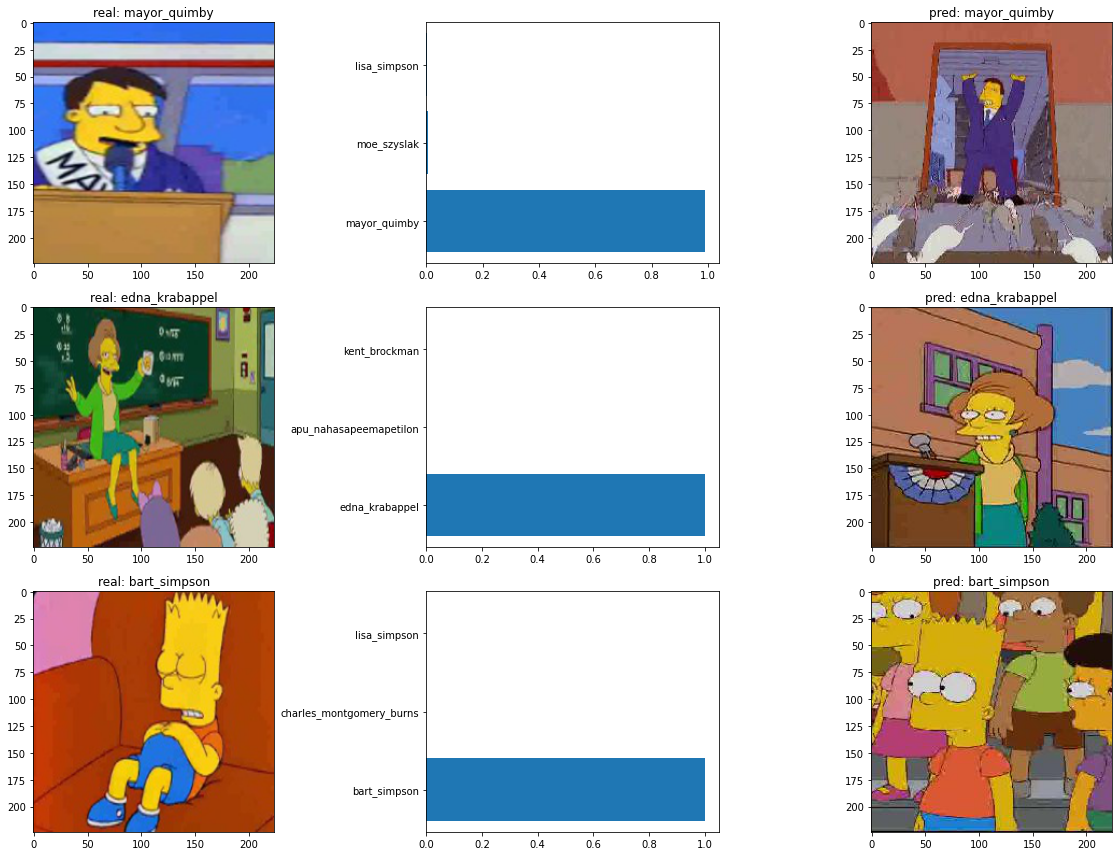

In [37]:
ShowPredictions(raw_image_paths,raw_image_labels,3)

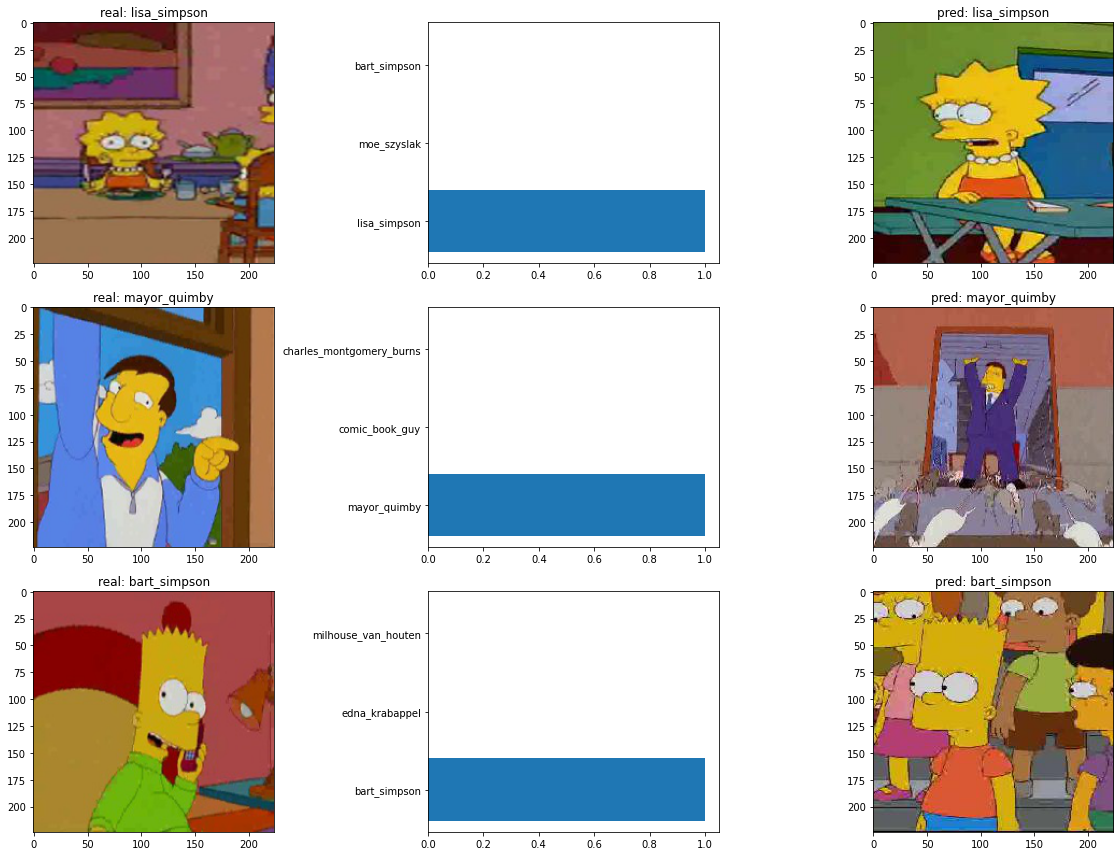

In [38]:
ShowPredictions(raw_image_paths,raw_image_labels,3)

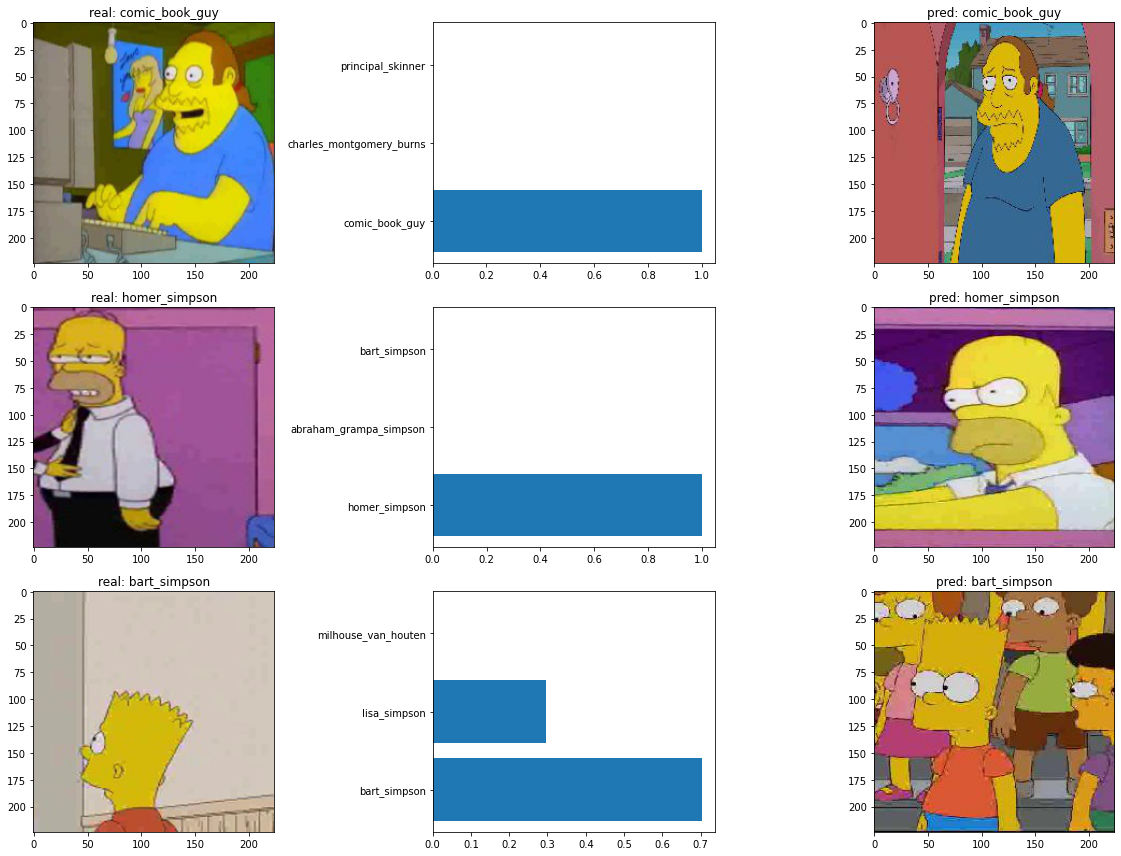

In [39]:
ShowPredictions(raw_image_paths,raw_image_labels,3)

In [40]:
def GetConfusionMatrix(model, test_loader):
    with torch.no_grad():
        model.eval()
        model.to(device)
        all_preds  = torch.FloatTensor([]).to(device)
        all_labels = torch.LongTensor([]).to(device)
        #compute all predictions
        for batch in test_loader:
            images,labels = batch
            images,labels = images.to(device),labels.to(device)
            preds = model(images)
            all_preds = torch.cat(
                (all_preds,preds),
                dim=0
            )
            all_labels = torch.cat((all_labels,labels),dim=0)
        
        #get the predicted labels
        preds = all_preds.argmax(dim=1)
        #create confusion matrix
        cm = confusion_matrix(all_labels.cpu().numpy(), preds.cpu().numpy())
        return cm
    

In [41]:
cm = GetConfusionMatrix(model,test_loader)

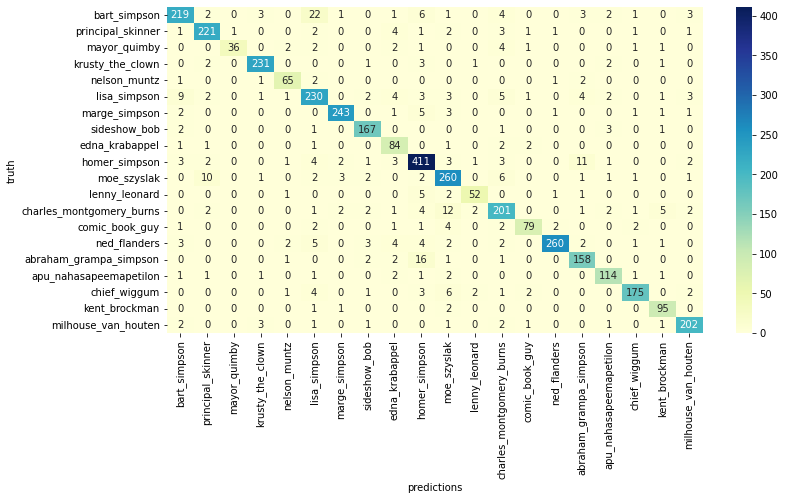

In [42]:
#display confusion matrix. truth:x_axis, preds:y_axis
df_cm = pd.DataFrame(cm, index = [i for i in class_list], columns = [i for i in class_list])
plt.figure(figsize=(12,6))
sns.heatmap(df_cm,annot=True,cmap="YlGnBu",fmt='g')
plt.xlabel('predictions')
plt.ylabel('truth')
plt.show()

## a. Overall Accuracy
Overal accuracy is important but it should be taken in caution as a high overal accuracy can be misleading.

In [43]:
def DisplayScores(class_list,scores,score_type = ''):
    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(class_list, scores)
    ax.bar_label(ax.containers[0],fmt='%.2f')
    ax.set_xticklabels(class_list, rotation=90)
    ax.set_title('mean_' + score_type +':'+ str(round(scores.mean(),ndigits=2)))
    plt.show()
    

In [44]:
# Be cautius, not always the best way
OveralAcc = np.sum(np.diag(cm))/np.sum(cm)
print('OverallAccuracy', OveralAcc)

OverallAccuracy 0.8972848360655737


## b. Recall
- Recall tells us the ability of algoritm to classify a particular class. 
- For example, we have 99 'kent_brockman' in testing set, sum of the 19th row. As we see above only 95 out of 99 is classified correctly. Out of 99, 1 is classified as 'lisa_simpson', 1 is classified as 'marge_simpson' and 2 are classified as 'moe_szyslak'...Thus, recall for lionel_hutz is 95/99=0.96 
- Notice that for some tasks, we must prioritize this score. For example, if we want to label a video good/bad for students where bad videos rarely occur, high recall for 'bad 'is very important. One can afford classifying good as bad but the other way.

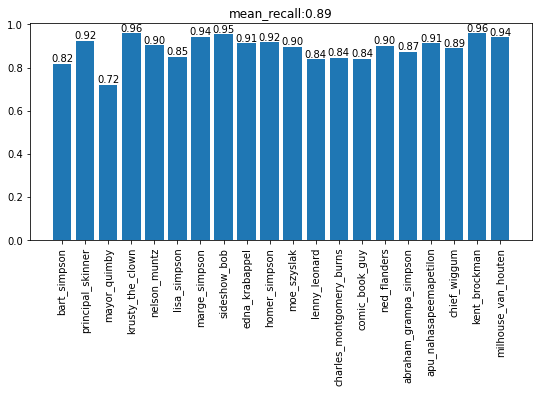

In [45]:
recalls = np.diag(cm)/np.sum(cm,axis = 1)
DisplayScores(class_list,recalls,'recall')

## c. Precision

- Precision for a class tells us the ability of an alg **not to label anything as that class**. 
- The 19th col above tells us 108 images are classified as 'kent_brockman' and 95 of them are correct. Thus precision for 'kent_brockman' is 95/108=0.88

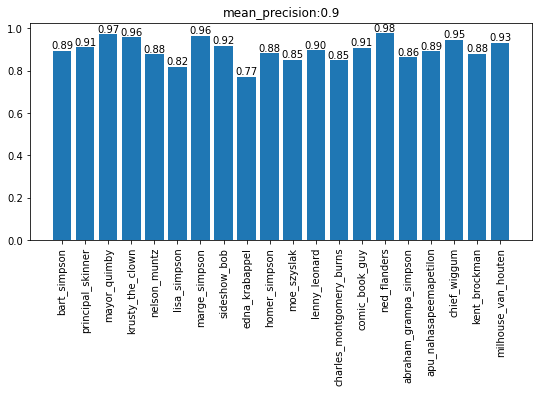

In [46]:
precisions = np.diag(cm)/np.sum(cm,axis = 0)
DisplayScores(class_list,precisions,'precision')

## d. F1-Score
This is the harmonic average of recall recall and precision. It is a realiable measure putting equal weigths on precison and recall. It sits somewhere between precision and recall. 

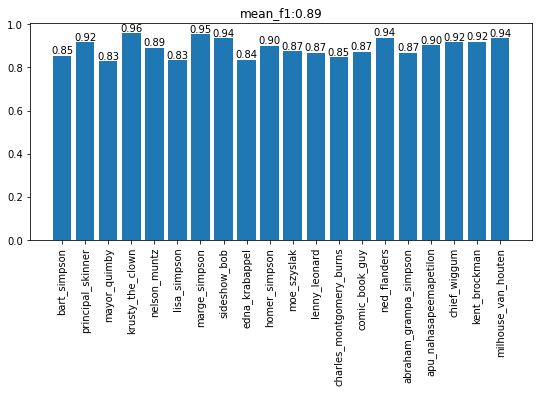

In [47]:
f1 = 2/(1/recalls + 1/precisions)
DisplayScores(class_list,f1,'f1')